# Predict Bike Sharing Demand with AutoGluon Template

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages and Setup Kaggle API Key


In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle
!pip install python-dotenv

from autogluon.tabular import TabularPredictor,TabularDataset
# Without --no-cache-dir, smaller aws instances may have trouble installing

import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

import os
import json
from dotenv import dotenv_values


  Using cached pip-22.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-62.3.3-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 kB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 153.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 212.2 MB/s eta 0:00:00
     ━━━━━━━

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
    !touch /root/.kaggle/kaggle.json
    !chmod 666 /root/.kaggle/kaggle.json

##############################################################
#SUGGESTED IN REVIEW: use dotenv to not disclose kaggle_username and kaggle_key
CONFIG = dotenv_values('.env')
kaggle_username = CONFIG['KAGGLE_USERNAME']
kaggle_key = CONFIG['KAGGLE_KEY']
#############################################################

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))
    !chmod 600 /root/.kaggle/kaggle.json

### Download and explore dataset

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 6.85MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',parse_dates=[0],infer_datetime_format=True)
#train.head()
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
display(train.describe())

# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test =  pd.read_csv('test.csv',parse_dates=[0],infer_datetime_format=True)
#test.head()

# Same thing as train and test dataset
submission =  pd.read_csv('sampleSubmission.csv',parse_dates=[0],infer_datetime_format=True)
#submission.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [7]:
#############################################################
#SUGGESTED IN REVIEW: USE learner_kwargs to leave out the two columns ['casual','registered'] 

TabularPredictor(label="count",eval_metric="root_mean_squared_error",problem_type="regression",learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(train_data=train, time_limit=600, presets="best_quality")
#############################################################


No path specified. Models will be saved in: "AutogluonModels/ag-20220606_020229/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220606_020229/"
AutoGluon Version:  0.4.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2959.95 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor=TabularPredictor.load("AutogluonModels/ag-20220606_020229/")
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.834327      10.877756  502.443407                0.001003           0.708654            3       True         16
1   RandomForestMSE_BAG_L2  -53.364830       9.963030  405.766930                0.589094          26.017799            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.953309       9.955625  387.960210                0.581690           8.211079            2       True         14
3          LightGBM_BAG_L2  -55.086518       9.625948  401.161386                0.252012          21.412255            2       True         11
4          CatBoost_BAG_L2  -55.592800       9.453957  446.093619                0.080022          66.344488            2       True         13
5        LightGBMXT_BAG_L2  -60.360798      12.386571  428.101337         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602

### Create predictions from test dataset

0    23.343060
1    42.180641
2    45.300087
3    48.270592
4    51.215614
Name: count, dtype: float32

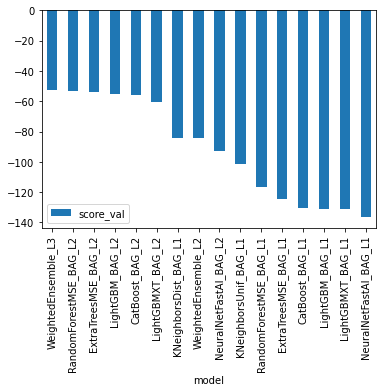

In [16]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")
predictions = predictor.predict(test)
predictions.head()

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [17]:
# Describe the `predictions` series to see if there are any negative values
# How many negative values do we have?
# Set them to zero

predictions.iloc[predictions.loc[predictions<0].index.tolist()]=0

### Set predictions to submission dataframe, save, and submit

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 241kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName                               date                 description                                      status    publicScore  privateScore  
-------------------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
submission.csv                         2022-05-29 16:25:57  first raw submission                             complete  1.80493      1.80493       


### Initial score of  1.80493

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


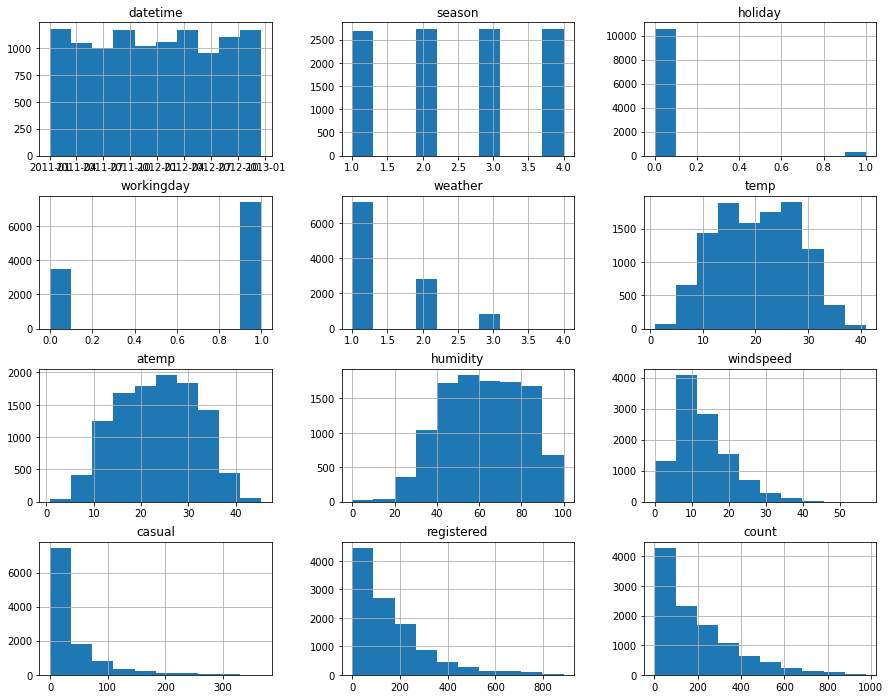

In [21]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
fig = plt.figure(figsize = (15,12));
ax = fig.gca();
train.hist(ax=ax,grid=True);

In [6]:
## create New features

# create new features:month,day_of_week,hour_of_day

train['month'] = train['datetime'].dt.month
train['day_of_week'] = train['datetime'].dt.dayofweek
train['hour_of_day']=train['datetime'].dt.hour

test['month'] = test['datetime'].dt.month
test['day_of_week'] = test['datetime'].dt.dayofweek #0 is monday 
test['hour_of_day']=test['datetime'].dt.hour

# create a new features:peak_hours_indicator for weekdays,weekends and holidays 

peaks_work=train.query('workingday==1 and holiday==0').groupby(['hour_of_day']).sum()[['count']].sort_values(by=['count'],ascending=True)
peaks_weekend=train.query('workingday==0 and holiday==0').groupby(['hour_of_day']).sum()[['count']].sort_values(by=['count'],ascending=True)
peaks_holiday=train.query('holiday==1').groupby(['hour_of_day']).sum()[['count']].sort_values(by=['count'],ascending=True)
peak_hrs_indicator=[]

for i in range(24):
    tmp_work=peaks_work.iloc[i].name
    tmp_weekend=peaks_weekend.iloc[i].name
    tmp_holiday=peaks_holiday.iloc[i].name
    
    tr_indices_work=train.query('hour_of_day==@tmp_work and workingday==1 and holiday==0').index.tolist()
    tr_indices_weekend=train.query('hour_of_day==@tmp_weekend and workingday==0 and holiday==0').index.tolist()
    tr_indices_holiday=train.query('hour_of_day==@tmp_holiday and holiday==1').index.tolist()
    
    train.loc[tr_indices_work,'peak_hour_indicator']=i
    train.loc[tr_indices_weekend,'peak_hour_indicator']=i
    train.loc[tr_indices_holiday,'peak_hour_indicator']=i
    
    tst_indices_work=test.query('hour_of_day==@tmp_work and workingday==1 and holiday==0').index.tolist()
    tst_indices_weekend=test.query('hour_of_day==@tmp_weekend and workingday==0 and holiday==0').index.tolist()
    tst_indices_holiday=test.query('hour_of_day==@tmp_holiday and holiday==1').index.tolist()

    test.loc[tst_indices_work,'peak_hour_indicator']=i
    test.loc[tst_indices_weekend,'peak_hour_indicator']=i
    test.loc[tst_indices_holiday,'peak_hour_indicator']=i
    
#train.drop('datetime', axis=1, inplace=True)
#test.drop('datetime', axis=1, inplace=True)    
#display(train.head(10))
#display(test.head(10))

# create new features:day_of_week_sin,day_of_week_cos 
#reference:https://www.mikulskibartosz.name/time-in-machine-learning/

train['day_of_week_sin'] = np.sin(train['day_of_week'] * (2 * np.pi / 7))
train['day_of_week_cos'] = np.cos(train['day_of_week'] * (2 * np.pi / 7))

train['month_sin'] = np.sin(train['month'] * (2 * np.pi / 7))
train['month_cos'] = np.cos(train['month'] * (2 * np.pi / 7))

test['day_of_week_sin'] = np.sin(test['day_of_week'] * (2 * np.pi / 7))
test['day_of_week_cos'] = np.cos(test['day_of_week'] * (2 * np.pi / 7))

test['month_sin'] = np.sin(test['month'] * (2 * np.pi / 7))
test['month_cos'] = np.cos(test['month'] * (2 * np.pi / 7))


#create new feature: AM/PM 
train.loc[train.query('hour_of_day>12').index.tolist(),'AM/PM']=1
train.loc[train.query('hour_of_day<=12').index.tolist(),'AM/PM']=0

test.loc[test.query('hour_of_day>12').index.tolist(),'AM/PM']=1
test.loc[test.query('hour_of_day<=12').index.tolist(),'AM/PM']=0

#create new df train_new training without columns 'day_of_week','hour_of_day','month','casual','registered'
train_cols_exclude=['day_of_week','hour_of_day','month']#,'casual','registered']

#create new df test_new without columns 'day_of_week','hour_of_day','month'
test_cols_exclude=['day_of_week','hour_of_day','month']

train_new=train.loc[:, ~train.columns.isin(train_cols_exclude)]
test_new=test.loc[:, ~test.columns.isin(test_cols_exclude)]

train_new.to_csv('train_new.csv', index=False)
test_new.to_csv('test_new.csv',index=False)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [7]:
col=['season', 'weather', 'AM/PM']

train_new = train_new.astype({"season":'category', "weather":'category', "AM/PM":'category'})
#test_new = train_new.astype({"season":'category', "weather":'category', "AM/PM":'category'})
display(train_new.dtypes)


datetime               datetime64[ns]
season                       category
holiday                         int64
workingday                      int64
weather                      category
temp                          float64
atemp                         float64
humidity                        int64
windspeed                     float64
casual                          int64
registered                      int64
count                           int64
peak_hour_indicator           float64
day_of_week_sin               float64
day_of_week_cos               float64
month_sin                     float64
month_cos                     float64
AM/PM                        category
dtype: object

## Step 5: Rerun the model with the same settings as before, just with more features

In [10]:
predictor_new_features = TabularPredictor(label="count",eval_metric="root_mean_squared_error",problem_type="regression",learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(train_data=train, time_limit=600, presets="best_quality",verbosity=4)

No path specified. Models will be saved in: "AutogluonModels/ag-20220606_021504/"
Presets specified: ['best_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True, 'verbosity': 4}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'excluded_model_types': None,
 'feature_generator': 'auto',
 'feature_prune_kwargs': None,
 'holdout_frac': None,
 'hyperparameter_tune_kwargs': None,
 'keep_only_best': False,
 'name_suffix': None,
 'num_bag_folds': None,
 'num_bag_sets': None,
 'num_stack_levels': None,
 'pseudo_data': None,
 'quantile_levels': None,
 'refit_full': False,
 'save_space': False,
 'set_best_to_refit_full': False,
 'unlabeled_data': None,
 'use_bag_holdout': False,
 'verbosity': 4}
Saving AutogluonModels/ag-20220606_021504/learner.pkl
Saving AutogluonModels/ag-20220606_021504/predictor.pkl
Beginning AutoGlu

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.988858      15.257221  526.891371                0.000967           0.484855            3       True         15
1          LightGBM_BAG_L2  -31.318629      14.519323  421.010169                0.421745          24.799112            2       True         11
2          CatBoost_BAG_L2  -31.406859      14.229703  476.909918                0.132124          80.698861            2       True         13
3        LightGBMXT_BAG_L2  -31.957773      14.702385  420.908543                0.604806          24.697486            2       True         10
4     ExtraTreesMSE_BAG_L2  -32.273193      14.701179  406.479522                0.603600          10.268465            2       True         14
5   RandomForestMSE_BAG_L2  -32.588239      14.708892  428.420416         

0    13.224506
1     8.976313
2     8.107357
3     6.997762
4     7.261266
Name: count, dtype: float32

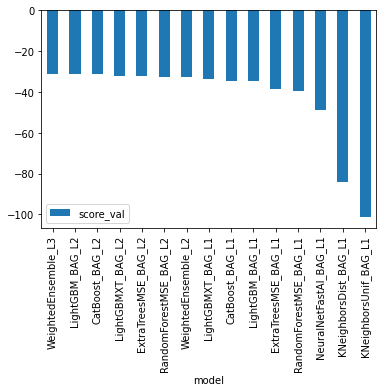

In [42]:
predictor_new_features.fit_summary()
predictor_new_features.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")
predictions_EDA = predictor_new_features.predict(test_new)
predictions_EDA.head()

In [43]:
# Remember to set all negative values to zero
# Describe the `predictions` series to see if there are any negative values
# How many negative values do we have?
# Set them to zero

predictions_EDA.iloc[predictions_EDA.loc[predictions_EDA<0].index.tolist()]=0

In [44]:
# Same submitting predictions
submission["count"] = predictions_EDA
submission.to_csv("submission_new_features.csv", index=False)

In [45]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "Final EDA new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 375kB/s]
Successfully submitted to Bike Sharing Demand

In [46]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName                               date                 description                                      status    publicScore  privateScore  
-------------------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
submission_new_features.csv            2022-05-30 02:06:32  Final EDA new features                           complete  0.63824      0.63824       
tail: write error: Broken pipe


### New Features Score of 0.63824 

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

### `hyperparameter_tune_kwargs`: 
* these parameters control how the model approaches HPO through # of HPO 'epochs' or 'num_trials' to run. It also controls the parameters **searcher** and **scheduler** that is in-charge of the HPO search 
* Instead of setting **num_trials**, I opt to remove the constrain on **time_limit** and let each model saturate (the more time-consuming option)

 I set **epochs** to 240, **searcher** to'random' and **scheduler** to'local'
  
### `hyperparameter`:
* In the EDA_run, using verbosity=4, you can see that: 
    * The models that contribute the most to *WeightedEnsemble_L3* are *LightGBMXT_BAG_L1* and *KNeighborsUnif_BAG_L1*
    * While *RandomForestMSE_BAG_L1* and *KNeighborsDist_BAG_L1* have the heighest weight in forming *WeightedEnsemble_L2*
    
 So I decided to tune **RF,GBM & KNN** models 

In [22]:
#most dominanant in L2: RandomForestMSE_BAG_L1  , KNeighborsDist_BAG_L1  
#most dominanant in L3: LightGBMXT_BAG_L1  , KNeighborsUnif_BAG_L1 

import autogluon.core as ag

hyperparameters={
    'RF': {
        'criterion': 'squared_error',
        'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
        'max_depth': ag.space.Int(lower=5, upper=19),
        'max_features': ag.space.Categorical('sqrt', 'log2')},

    'GBM':{
        'learning_rate' : ag.space.Real(1e-3,1e-2,default=0.01,log=True),
        'num_leaves': ag.space.Int(33, 60,default=40),#31 < 2^max_depth
        'max_depth':6,
        'extra_trees': ag.space.Categorical(True,False), 
        'boosting':ag.space.Categorical('gbdt')},#,'rf')}, #default = gbdt        # ‘GBMLarge’
    'KNN':{
        'algorithm':'auto',
        #'leaf_size': ag.space.Int(28, 40,default=35), depend on algo
        'n_neighbors':ag.space.Int(7,10,default=7), 
        'weights': ag.space.Categorical('uniform', 'distance')}
    #'XT':{
    #    'criterion': 'squared_error', 
    #    'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']},
    #    'max_features': ag.space.Categorical('sqrt', 'log2',None)}, #new
    #    #'max_depth': ag.space.Int(lower=5, upper=19)}
}
hyperparameter_tune_kwargs={
    'searcher':'random',
    'scheduler':'local',
    'epochs': 240
}

#time_limit=600
predictor_new_hpo_tuning = TabularPredictor(label="count",eval_metric="root_mean_squared_error",problem_type="regression",learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(train_data=train_new, presets="best_quality",hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20220608_000531/"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220608_000531/"
AutoGluon Version:  0.4.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 17
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['casual', 'registered']
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2072.62 MB
	Train Data (Original)  Memory Usage: 1.08 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGene

[1000]	valid_set's rmse: 38.1411
[2000]	valid_set's rmse: 35.1542
[3000]	valid_set's rmse: 33.9325
[4000]	valid_set's rmse: 33.3153
[5000]	valid_set's rmse: 32.947
[6000]	valid_set's rmse: 32.7265
[7000]	valid_set's rmse: 32.5788
[8000]	valid_set's rmse: 32.5161
[9000]	valid_set's rmse: 32.4847
[10000]	valid_set's rmse: 32.4646


100%|██████████| 1/1 [00:19<00:00, 19.52s/it]
Fitted model: LightGBM_BAG_L1/T1 ...
	-32.4611	 = Validation score   (root_mean_squared_error)
	15.46s	 = Training   runtime
	1.81s	 = Validation runtime
Hyperparameter tuning model: RandomForestMSE_BAG_L1 ...
100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
Fitted model: RandomForestMSE_BAG_L1/T1 ...
	-85.8481	 = Validation score   (root_mean_squared_error)
	1.34s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: KNeighbors_BAG_L1/T1 ...
	-113.3291	 = Validation score   (root_mean_squared_error)
	0.05s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: LightGBM_BAG_L1/T1 ...
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-34.0299	 = Validation score   (root_mean_squared_error)
	153.42s	 = Training   runtime
	38.29s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1/T1 ...
	-85.8481	 = Validation score   (root_mean_squared_error)
	1.34s	 = Training   runtime
	0.31s

[1000]	valid_set's rmse: 37.7683


100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
Fitted model: LightGBM_BAG_L2/T1 ...
	-37.7016	 = Validation score   (root_mean_squared_error)
	2.93s	 = Training   runtime
	0.15s	 = Validation runtime
Hyperparameter tuning model: RandomForestMSE_BAG_L2 ...
100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
Fitted model: RandomForestMSE_BAG_L2/T1 ...
	-47.1234	 = Validation score   (root_mean_squared_error)
	1.64s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: LightGBM_BAG_L2/T1 ...
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-34.0388	 = Validation score   (root_mean_squared_error)
	44.1s	 = Training   runtime
	2.78s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2/T1 ...
	-47.1234	 = Validation score   (root_mean_squared_error)
	1.64s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ...
	-34.0388	 = Validation score   (root_mean_squared_error)
	0.27s	 = Training   runtime
	0.0s	 = Valid

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L2  -33.987613      38.398323  153.806006                0.001109           0.338547            2       True          4
1         LightGBM_BAG_L1/T1  -34.029858      38.291862  153.420155               38.291862         153.420155            1       True          2
2         LightGBM_BAG_L2/T1  -34.038750      41.481711  198.909606                2.775381          44.101828            2       True          5
3        WeightedEnsemble_L3  -34.038750      41.482737  199.176965                0.001025           0.267360            3       True          7
4  RandomForestMSE_BAG_L2/T1  -47.123434      39.005960  156.451609                0.299630           1.643832            2       True          6
5  RandomForestMSE_BAG_L1/T1  -85.848097       0.309116    1.3

<AxesSubplot:xlabel='model'>

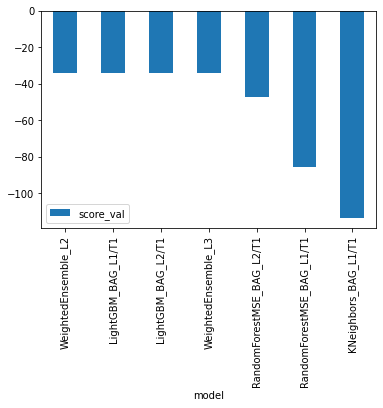

In [23]:
#predictor_new_hpo_tuning=TabularPredictor.load("AutogluonModels/ag-20220608_000531/")
predictor_new_hpo_tuning.fit_summary()
predictor_new_hpo_tuning.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [25]:
predictions_hpo_tune = predictor_new_hpo_tuning.predict(test_new)
predictions_hpo_tune.iloc[predictions_hpo_tune.loc[predictions_hpo_tune<0].index.tolist()]=0
# Same submitting predictions
submission["count"] = predictions_hpo_tune
submission.to_csv("submission_new_hpo_tuning.csv", index=False)
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_tuning.csv -m "EDA+hpo+tuning "
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 459kB/s]
Successfully submitted to Bike Sharing DemandfileName                               date                 description                                      status    publicScore  privateScore  
-------------------------------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
submission_new_hpo_tuning.csv          2022-06-08 00:11:10  EDA+hpo+tuning                                   complete  0.54930      0.54930       
tail: write error: Broken pipe


### HPO Tuning Score of 0.5493

## Step 7: Write a Report
### Creating plots and table for report

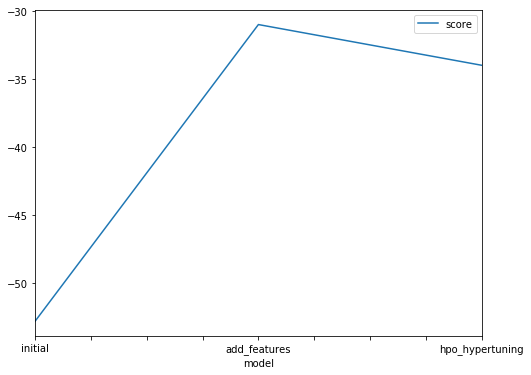

In [4]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features","hpo_hypertuning"],
        "score": [-52.834327, -30.988858,-33.987613]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

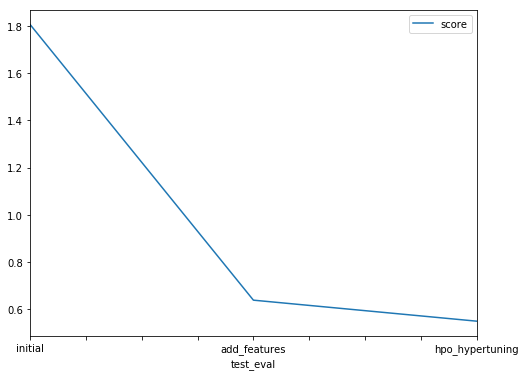

In [3]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features","hpo_hypertuning"],
        "score": [1.80493, 0.63824, 0.54930]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

* **preset**='best_quality' infers the following parameters: 
    - **model**: Categorical(‘coat_lite_small’, ‘twins_pcpvt_base’, ‘swin_base_patch4_window7_224’),
    - **lr**: Real(1e-5, 1e-2, log=True), 
    - **batch_size**: Categorical(8, 16, 32, 64, 128)
    - **epochs**: 200, 
    - **early_stop_patience**: 50 
    - **num_trials**: 1024, ‘searcher’: ‘random’
    - **time_limit**: 12*3600

- User-definition over-rides preset, so unless otherwise mentioned in the following table, the values are driven from the definition of **preset**='best_quality' 

In [8]:
# The hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "preset": ["best_quality", "best_quality","best_quality"],
    "timelimit": [600, 600,'-'],
    "searcher":['-','-','random'],
    "scheduler":['-','-','local'],
    "epochs":['-','-','250'],
    "score": [1.80493, 0.63824,0.54930],
    "marginal_score":['-64.64%','0%','+13.94%']
},index=["initial", "add_features","hpo_hypertuning"])

,preset,timelimit,searcher,scheduler,epochs,score,marginal_score
initial,best_quality,600,-,-,-,1.80493,-64.64%
add_features,best_quality,600,,-,-,0.63824,0%
hpo_hypertuning,best_quality,-,random,local,250,0.54930,+13.94%
